In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed, AdditiveAttention, Concatenate
from tensorflow.keras.optimizers import Adam

2025-04-15 12:01:27.828597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744718488.025152      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744718488.081506      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=783aaecb1695478ec5c9776618ed65d57655c9190aea592a85d16602389c42a1
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [3]:
data = pd.read_csv('/kaggle/input/eurusd60/EURUSD-60-DS.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [4]:
import pandas_ta as ta
data['ema20'] = ta.ema(data['Close'],length=20)
data['ema50'] = ta.ema(data['Close'],length=50) # اختلاف قیمت

# انتخاب ویژگی‌های ورودی
features = ['ema20']
target = ['ema20', 'ema50']  # خروجی هدف
data.dropna(inplace=True)

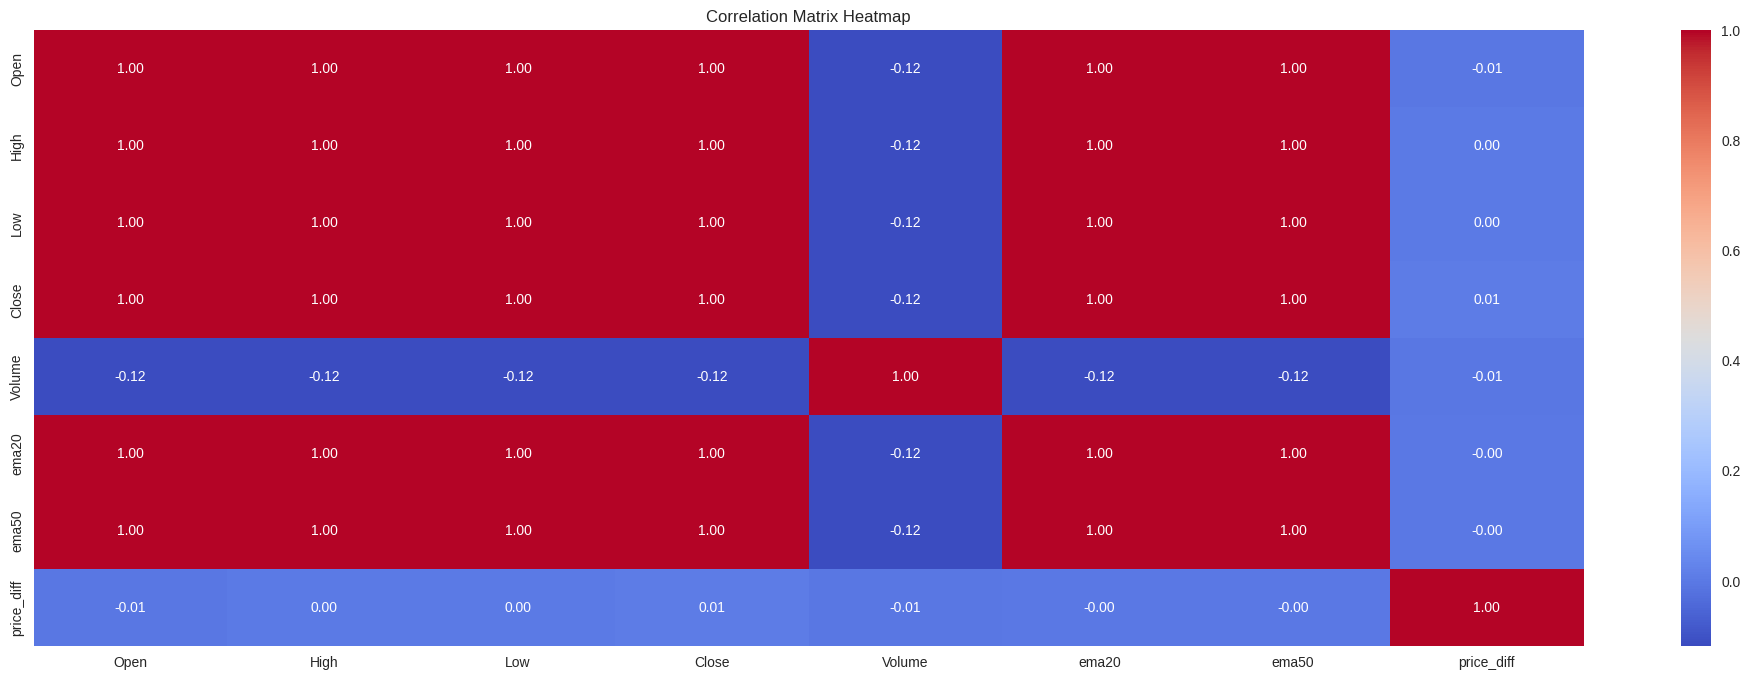

In [35]:
import seaborn as sns
correlation_matrix = data.drop(['Date'],axis=1).corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f",annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

/tmp/ipykernel_31/283547170.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # استفاده از تم seaborn برای ظاهر بهتر


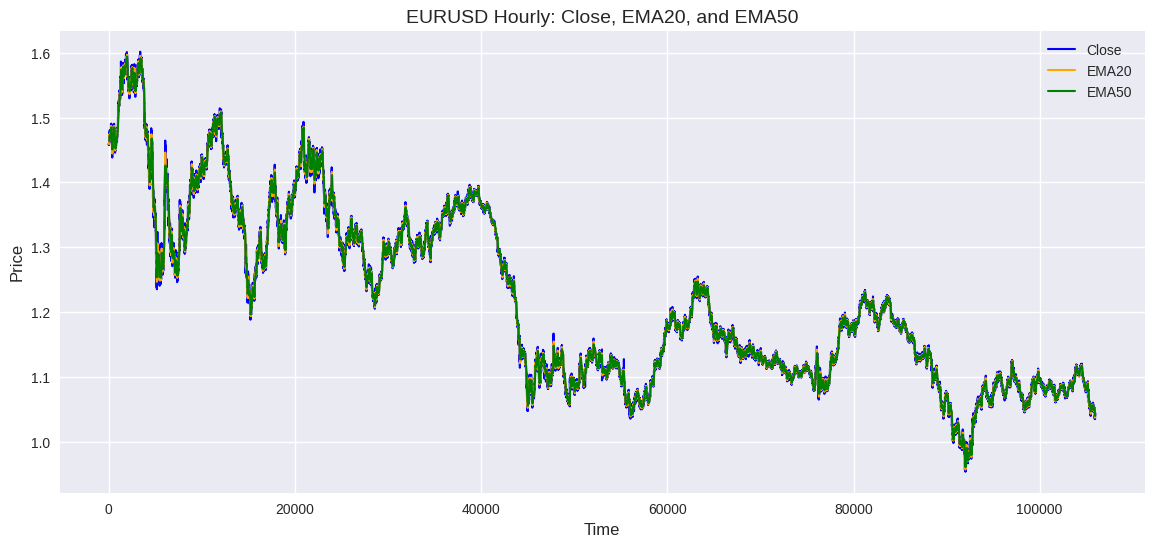

In [36]:
plt.style.use('seaborn')  # استفاده از تم seaborn برای ظاهر بهتر
plt.rcParams['figure.figsize'] = (14, 6)  # اندازه نمودا

# رسم لاین پلات
plt.plot(data['Close'], label='Close', color='blue', linewidth=1.5)
plt.plot(data['ema20'], label='EMA20', color='orange', linewidth=1.5)
plt.plot(data['ema50'], label='EMA50', color='green', linewidth=1.5)

# افزودن عنوان و برچسب‌ها
plt.title('EURUSD Hourly: Close, EMA20, and EMA50', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)

# نمایش لجند
plt.legend()

In [5]:
def prepare_data(data, features, target, seq_length=60, future_steps=24):
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    
    # نرمال‌سازی ویژگی‌ها و هدف
    data_scaled_features = scaler_features.fit_transform(data[features])
    data_scaled_target = scaler_target.fit_transform(data[target])
    
    X, y = [], []
    for i in range(len(data_scaled_features) - seq_length - future_steps):
        X.append(data_scaled_features[i:i+seq_length])
        y.append(data_scaled_target[i+seq_length:i+seq_length+future_steps])
    
    X = np.array(X)
    y = np.array(y)
    
    # تقسیم داده‌ها به train، validation و test
    train_size = int(0.7 * len(X))  # 70% برای آموزش
    val_size = int(0.15 * len(X))   # 15% برای اعتبارسنجی
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    
    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler_features, scaler_target

X_train, y_train, X_val, y_val, X_test, y_test, scaler_features, scaler_target = prepare_data(
    data, features, target, seq_length=30, future_steps=15)

In [34]:
del model

In [6]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, MultiHeadAttention, Concatenate, TimeDistributed

def build_seq2seq_with_multihead_attention(seq_length, future_steps, n_features):
    # ورودی
    encoder_inputs = Input(shape=(seq_length, n_features))
    
    # انکودر
    encoder_lstm_1 = LSTM(100, activation='tanh', return_sequences=True)(encoder_inputs)
    encoder_dropout_1 = Dropout(0.2)(encoder_lstm_1)  # افزایش Dropout
    encoder_lstm_2, state_h, state_c = LSTM(100, activation='tanh', return_state=True)(encoder_dropout_1)
    encoder_states = [state_h, state_c]
    
    # دکودر
    decoder_inputs = RepeatVector(future_steps)(encoder_lstm_2)
    decoder_lstm_1 = LSTM(100, activation='tanh', return_sequences=True)(decoder_inputs, initial_state=encoder_states)
    decoder_dropout_1 = Dropout(0.2)(decoder_lstm_1)  # افزایش Dropout
    decoder_lstm_2 = LSTM(100, activation='tanh', return_sequences=True)(decoder_dropout_1)
    
    # MultiHeadAttention
    attention = MultiHeadAttention(num_heads=4, key_dim=100 // 4)(query=decoder_lstm_2, key=encoder_dropout_1, value=encoder_dropout_1)
    concat = Concatenate()([decoder_lstm_2, attention])
    
    # خروجی
    decoder_dense = TimeDistributed(Dense(2))(concat)
    
    # تعریف مدل
    model = Model(inputs=encoder_inputs, outputs=decoder_dense)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae','mape'])  # کاهش نرخ یادگیری
    return model
# # ساخت مدل
# model = build_seq2seq_with_attention(seq_length=30, future_steps=15, n_features=len(features))
# model.summary()
# def build_seq2seq_model(seq_length, future_steps):
#     model = Sequential()
#     model.add(LSTM(100, activation='relu', input_shape=(seq_length, len(features)), return_sequences=False))
#     model.add(RepeatVector(future_steps))
#     model.add(LSTM(100, activation='relu', return_sequences=True))
#     model.add(TimeDistributed(Dense(2)))
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',metrics=['mae'])
#     return model

# model = build_seq2seq_model(seq_length=30, future_steps=15)
# model.summary()

# def build_lstm_model(seq_length, future_steps, n_features):
#     model = Sequential()
#     model.add(LSTM(64, activation='tanh', input_shape=(seq_length, n_features), return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32, activation='tanh', return_sequences=False))
#     model.add(Dropout(0.2))
#     model.add(Dense(future_steps * 2))  # 24 تایم‌فریم × 2 متغیر (ema20 و ema50)
#     model.add(tf.keras.layers.Reshape((future_steps, 2)))  # تغییر شکل خروجی به (future_steps, 2)
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
#     return model

model = build_seq2seq_with_multihead_attention(seq_length=30, future_steps=15, n_features=len(features))
model.summary()

I0000 00:00:1744718535.433914      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 30, 100)        │         40,800 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 30, 100)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 100), (None,   │         80,400 │ dropout[0][0]          │
│                           │ 100), (None, 100)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 15, 100)        │              0 │ lstm_1[0][0]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 15, 100)        │         80,400 │ repeat_vector[0][0],   │
│                           │                        │                │ lstm_1[0][1],          │
│                           │                        │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 15, 100)        │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 15, 100)        │         80,400 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 15, 100)        │         40,400 │ dropout[0][0],         │
│ (MultiHeadAttention)      │                        │                │ lstm_3[0][0],          │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 15, 200)        │              0 │ lstm_3[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 15, 2)          │            402 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 322,802 (1.23 MB)

 Trainable params: 322,802 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# تعریف EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # معیار مانیتورینگ
    patience=10,                  # تعداد epochهایی که صبر می‌کنه
    restore_best_weights=False,   # وزن‌ها به بهترین حالت برنمی‌گردن
    start_from_epoch=10,          # از epoch دهم شروع به چک کردن می‌کنه
    verbose=1                     # گزارش رو چاپ می‌کنه
)

# تعریف ReduceLROnPlateau برای تنظیم نرخ یادگیری
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # معیار مانیتورینگ
    factor=0.25,                  # ضریب کاهش نرخ یادگیری
    patience=5,                   # تعداد epochهایی که صبر می‌کنه
    min_lr=1e-7,                  # حداقل نرخ یادگیری
    verbose=1                     # گزارش تغییرات رو چاپ می‌کنه
)

# آموزش مدل با همه callbackها
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


I0000 00:00:1744718551.809998      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


2316/2316 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0047 - mae: 0.0228 - mape: 5.1275 - val_loss: 2.7869e-05 - val_mae: 0.0041 - val_mape: 1.4647 - learning_rate: 5.0000e-04
Epoch 2/100
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 9.8600e-05 - mae: 0.0073 - mape: 1.6218 - val_loss: 3.9139e-05 - val_mae: 0.0052 - val_mape: 1.8590 - learning_rate: 5.0000e-04
Epoch 3/100
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 8.3620e-05 - mae: 0.0067 - mape: 1.4954 - val_loss: 1.4370e-05 - val_mae: 0.0028 - val_mape: 1.0226 - learning_rate: 5.0000e-04
Epoch 4/100
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 6.1946e-05 - mae: 0.0057 - mape: 1.2980 - val_loss: 9.7014e-06 - val_mae: 0.0023 - val_mape: 0.8254 - learning_rate: 5.0000e-04
Epoch 5/100
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 4.5989e-05 - mae: 0.0050 - mape: 1.1601 - val_loss: 1.4814e-05 - val_mae: 0.0030 - val_mape: 1.0721 - learning_rate: 5.0000e-04
Epoch 6/100
2312/2316 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

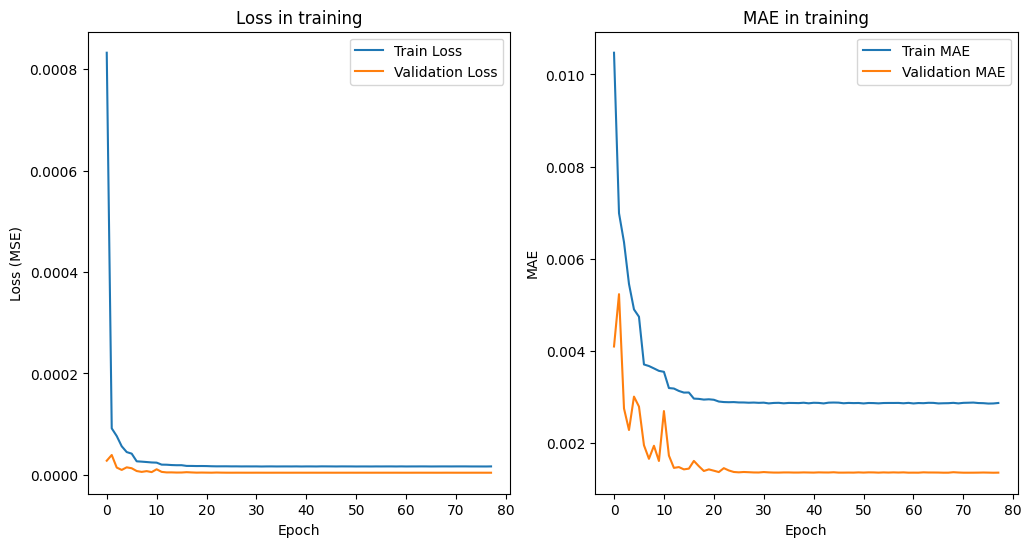

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [9]:
y_pred = model.predict(X_test)

# معکوس کردن مقیاس برای تفسیر
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)



497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [10]:
y_pred_rescaled[0]

array([[1.0717163, 1.072341 ],
       [1.071582 , 1.0723401],
       [1.0713801, 1.0722022],
       [1.0711998, 1.0720518],
       [1.0710785, 1.0719357],
       [1.0710068, 1.0718559],
       [1.0709622, 1.0718001],
       [1.0709258, 1.0717547],
       [1.070887 , 1.0717107],
       [1.0708417, 1.0716635],
       [1.0707903, 1.0716122],
       [1.0707353, 1.0715578],
       [1.0706795, 1.0715021],
       [1.0706257, 1.0714468],
       [1.0705754, 1.071394 ]], dtype=float32)

In [11]:
y_test_rescaled[0]

array([[1.07113321, 1.07180872],
       [1.07097005, 1.07171505],
       [1.07077862, 1.07160701],
       [1.07055303, 1.07148163],
       [1.07030989, 1.0713451 ],
       [1.0700518 , 1.07119823],
       [1.06987068, 1.07107869],
       [1.06971728, 1.07096816],
       [1.06949849, 1.07082901],
       [1.06940816, 1.07073964],
       [1.06934357, 1.07066083],
       [1.06920895, 1.07055374],
       [1.06907   , 1.07044379],
       [1.06890714, 1.07032286],
       [1.06864837, 1.07016078]])

/tmp/ipykernel_31/4201925820.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


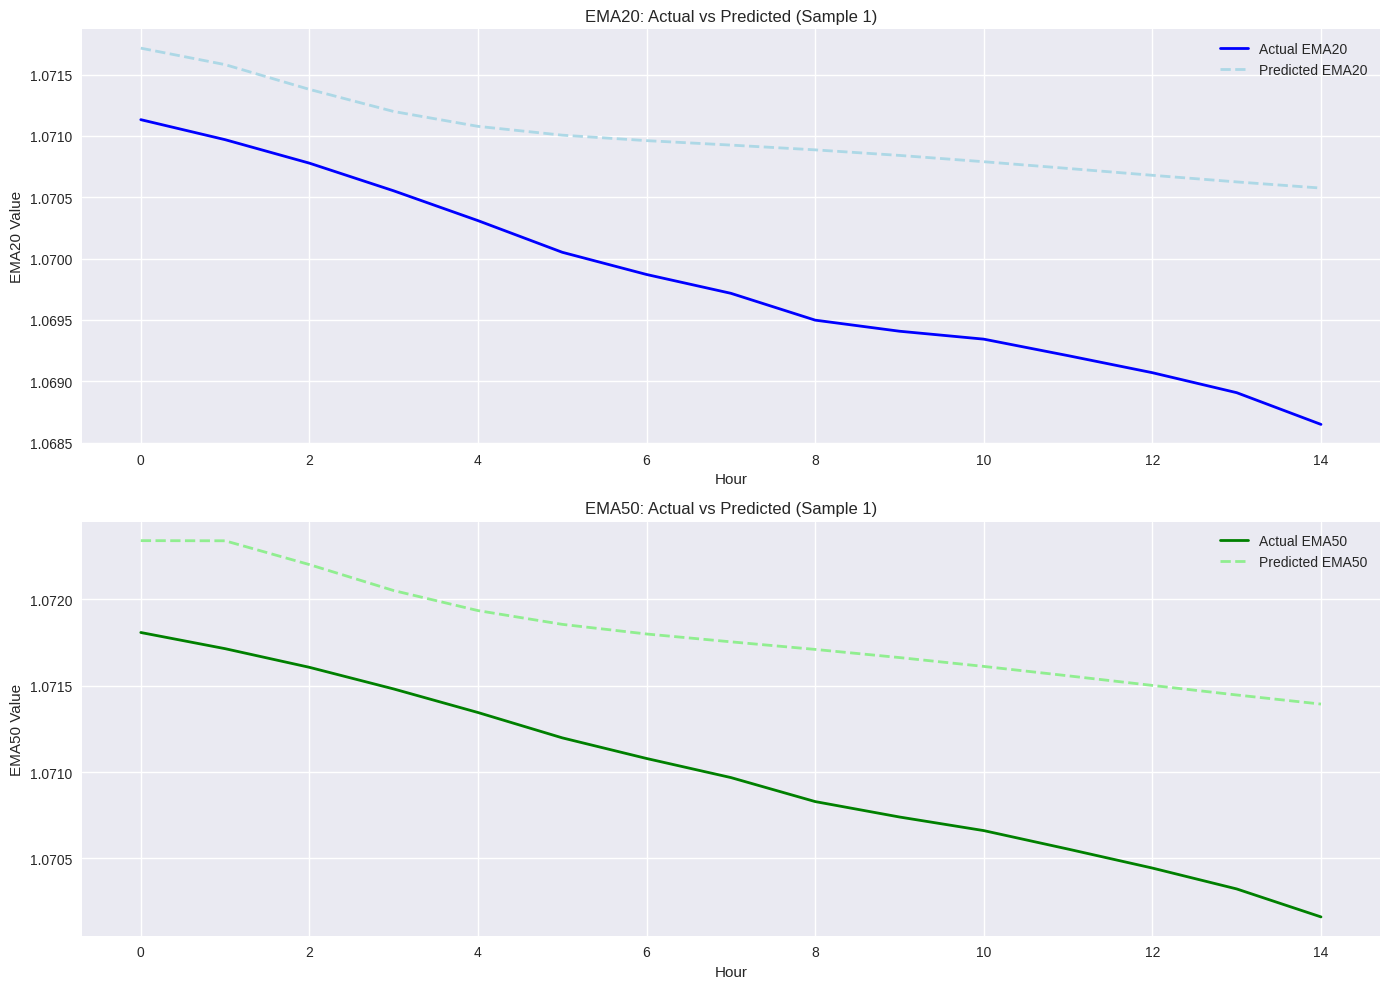

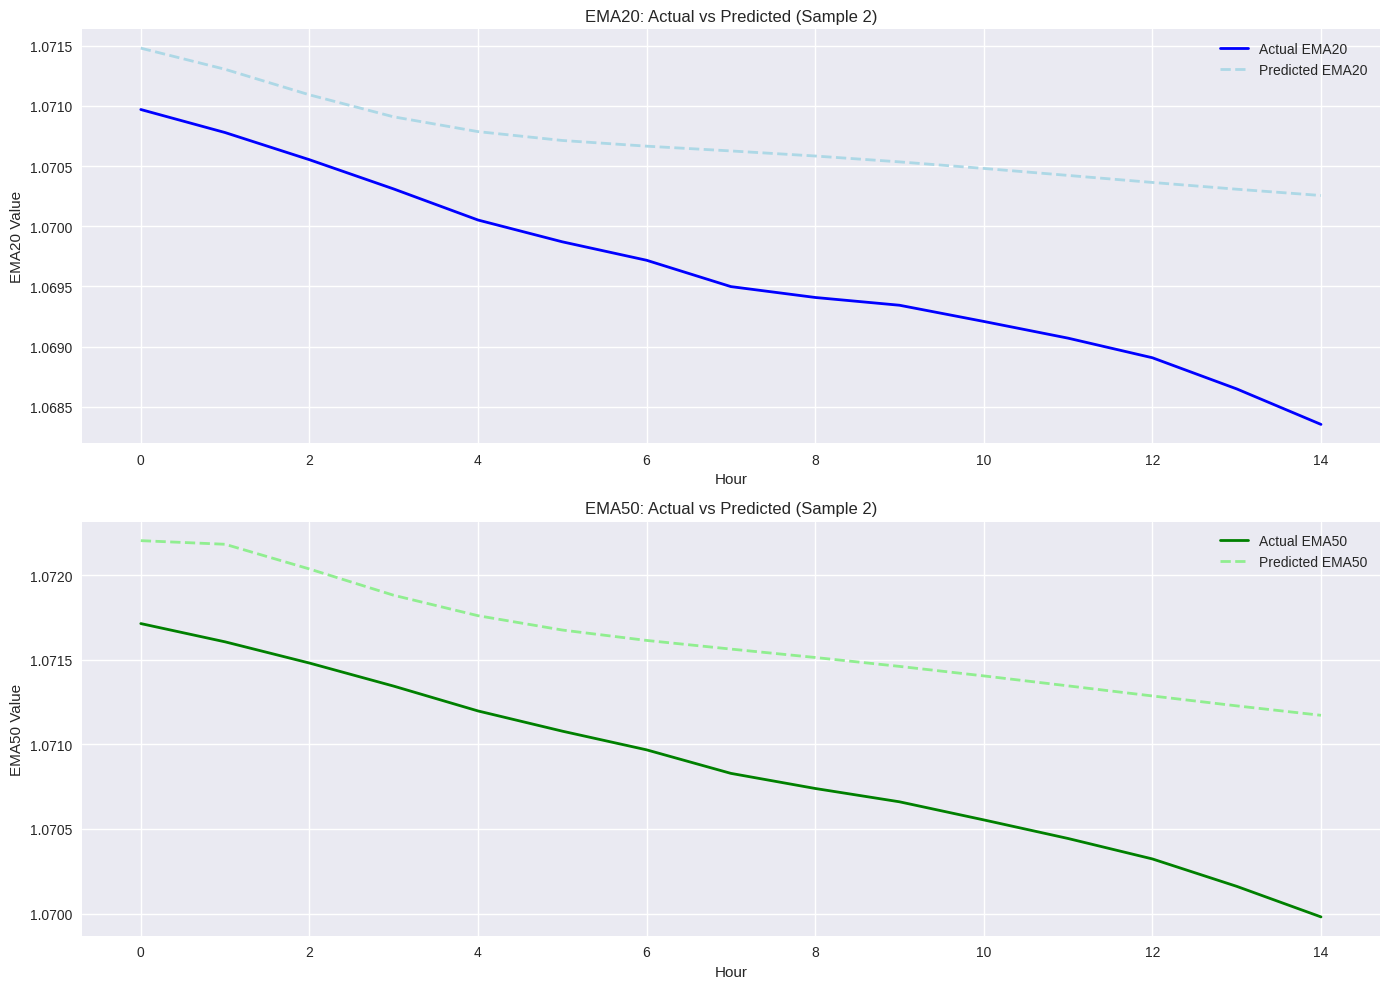

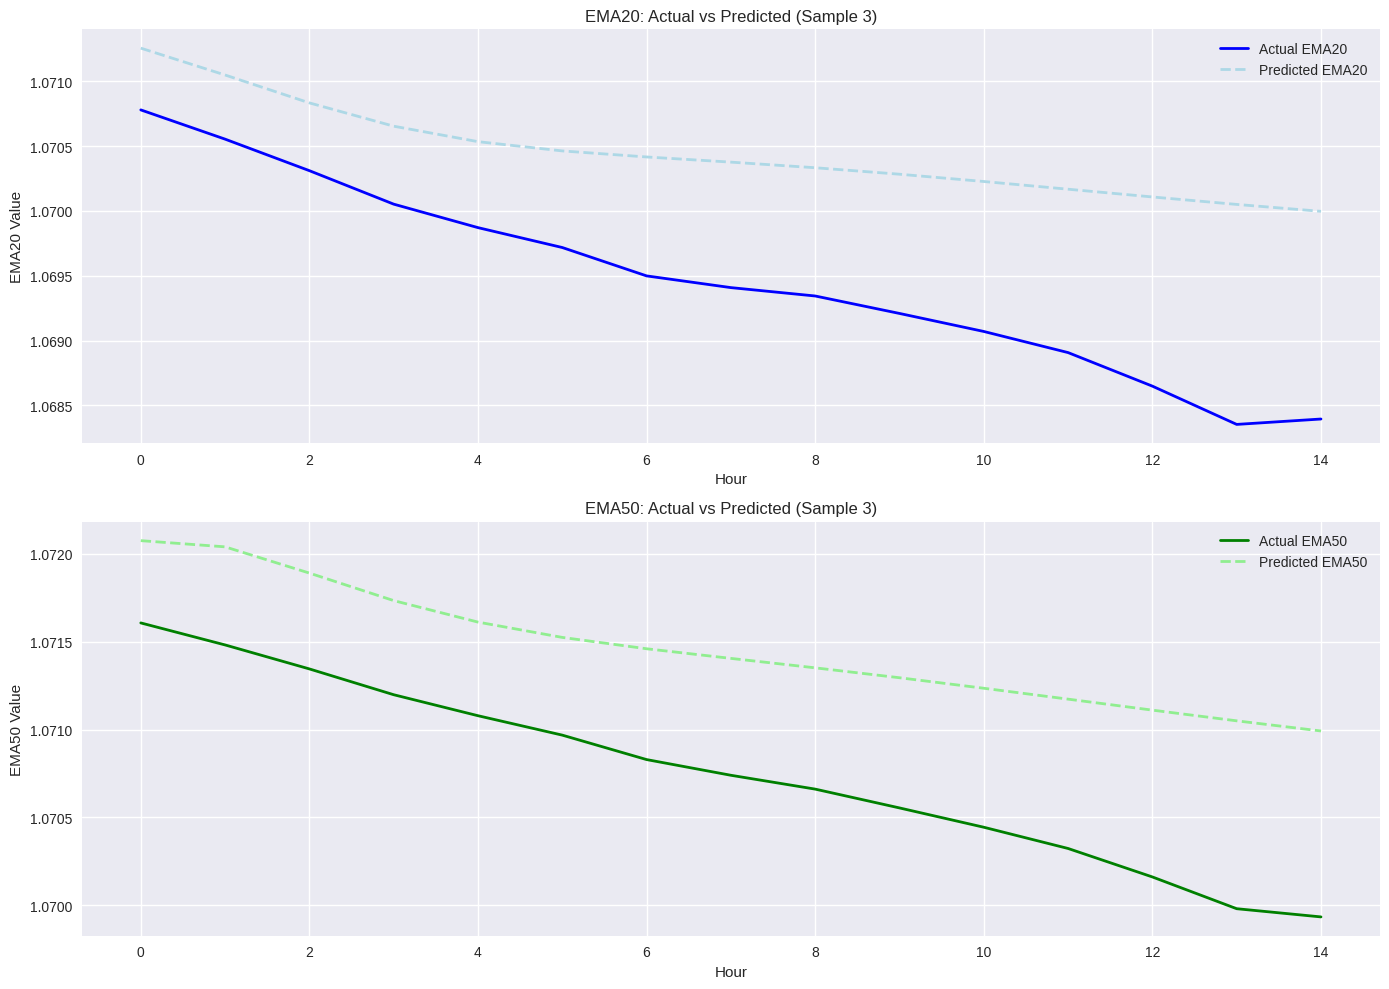

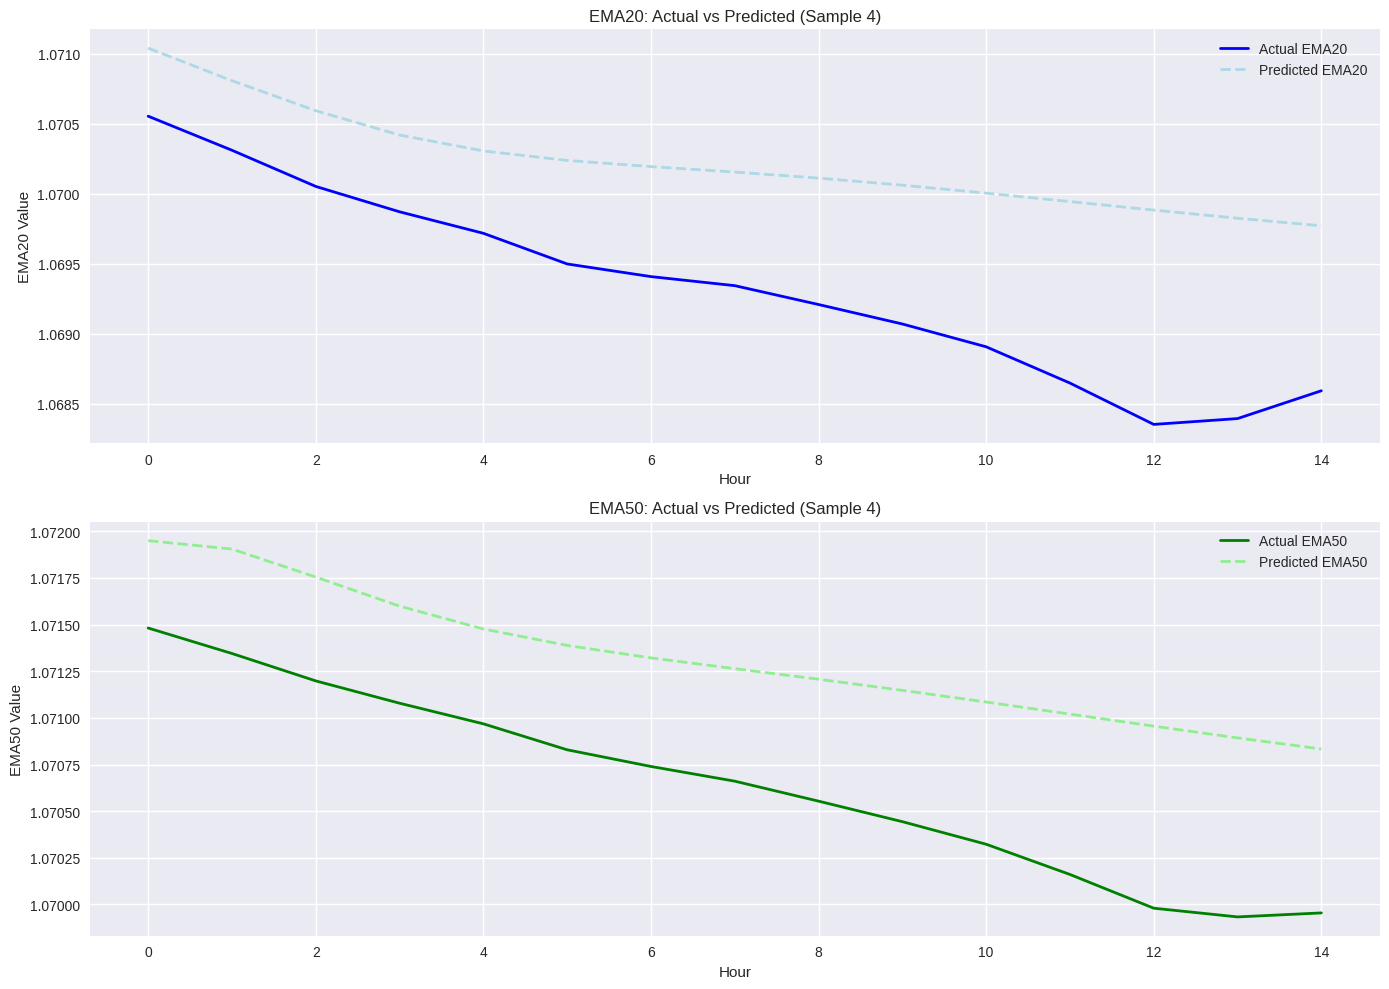

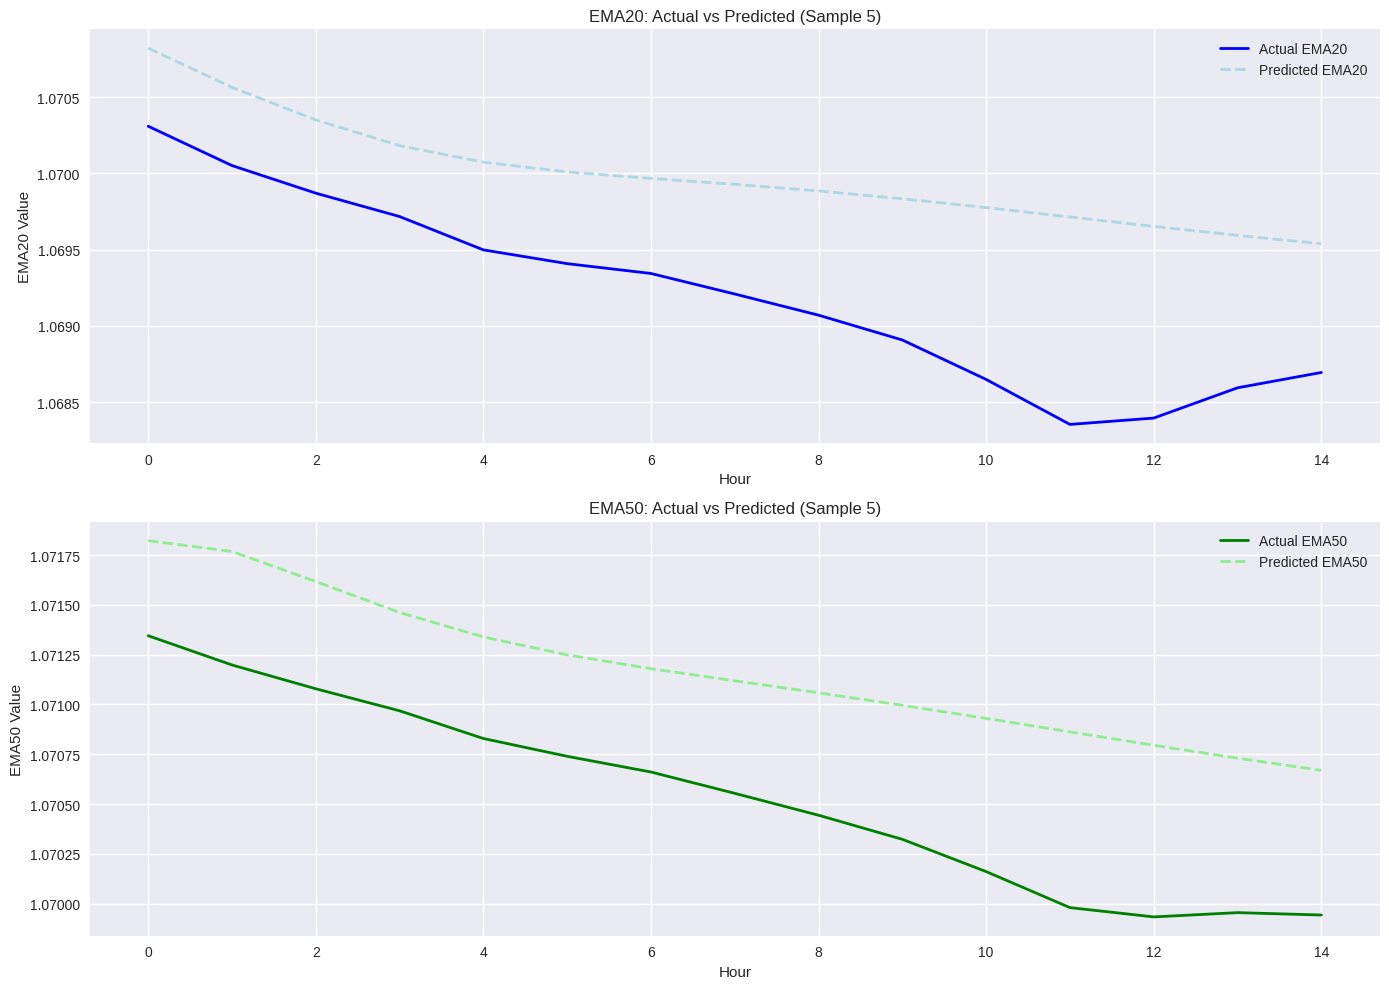

معیارهای دقت برای EMA20:
MSE: 0.000003
MAE: 0.001141

معیارهای دقت برای EMA50:
MSE: 0.000001
MAE: 0.000702


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# تنظیمات ظاهری نمودار
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 10)

# انتخاب تعداد نمونه‌ها برای نمایش (مثلاً 5 سری پیش‌بینی)
n_samples_to_plot = 5

# رسم نمودار برای EMA20 و EMA50
for sample_idx in range(min(n_samples_to_plot, y_test_rescaled.shape[0])):
    # داده‌های واقعی و پیش‌بینی‌شده برای نمونه خاص
    actual_ema20 = y_test_rescaled[sample_idx, :, 0]  # EMA20 واقعی
    actual_ema50 = y_test_rescaled[sample_idx, :, 1]  # EMA50 واقعی
    pred_ema20 = y_pred_rescaled[sample_idx, :, 0]    # EMA20 پیش‌بینی‌شده
    pred_ema50 = y_pred_rescaled[sample_idx, :, 1]    # EMA50 پیش‌بینی‌شده
    
    # ایجاد نمودار
    plt.figure()
    
    # نمودار برای EMA20
    plt.subplot(2, 1, 1)
    plt.plot(actual_ema20, label='Actual EMA20', color='blue', linewidth=2)
    plt.plot(pred_ema20, label='Predicted EMA20', color='lightblue', linestyle='--', linewidth=2)
    plt.title(f'EMA20: Actual vs Predicted (Sample {sample_idx + 1})')
    plt.xlabel('Hour')
    plt.ylabel('EMA20 Value')
    plt.legend()
    plt.grid(True)
    
    # نمودار برای EMA50
    plt.subplot(2, 1, 2)
    plt.plot(actual_ema50, label='Actual EMA50', color='green', linewidth=2)
    plt.plot(pred_ema50, label='Predicted EMA50', color='lightgreen', linestyle='--', linewidth=2)
    plt.title(f'EMA50: Actual vs Predicted (Sample {sample_idx + 1})')
    plt.xlabel('Hour')
    plt.ylabel('EMA50 Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# محاسبه و نمایش معیارهای دقت (MSE و MAE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_ema20 = mean_squared_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())
mae_ema20 = mean_absolute_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())
mse_ema50 = mean_squared_error(y_test_rescaled[:, :, 1].flatten(), y_pred_rescaled[:, :, 1].flatten())
mae_ema50 = mean_absolute_error(y_test_rescaled[:, :, 1].flatten(), y_pred_rescaled[:, :, 1].flatten())

print("معیارهای دقت برای EMA20:")
print(f"MSE: {mse_ema20:.6f}")
print(f"MAE: {mae_ema20:.6f}")
print("\nمعیارهای دقت برای EMA50:")
print(f"MSE: {mse_ema50:.6f}")
print(f"MAE: {mae_ema50:.6f}")

In [13]:
forecast_ema20 = []
forecast_ema50 = []
forecast_ema20.extend(y_pred_rescaled[0, :, 0])
forecast_ema50.extend(y_pred_rescaled[0, :, 1])
for i in range(1, y_pred_rescaled.shape[0]):
    forecast_ema20.append(y_pred_rescaled[i, -1, 0])
    forecast_ema50.append(y_pred_rescaled[i, -1, 1])

# داده‌های واقعی
total_timesteps = len(forecast_ema20)
start_idx = len(data) - total_timesteps
actual_ema20 = data['ema20'].values[start_idx:start_idx + total_timesteps]
actual_ema50 = data['ema50'].values[start_idx:start_idx + total_timesteps]
close_values = data['Close'].values[start_idx:start_idx + total_timesteps]

/tmp/ipykernel_31/507712032.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


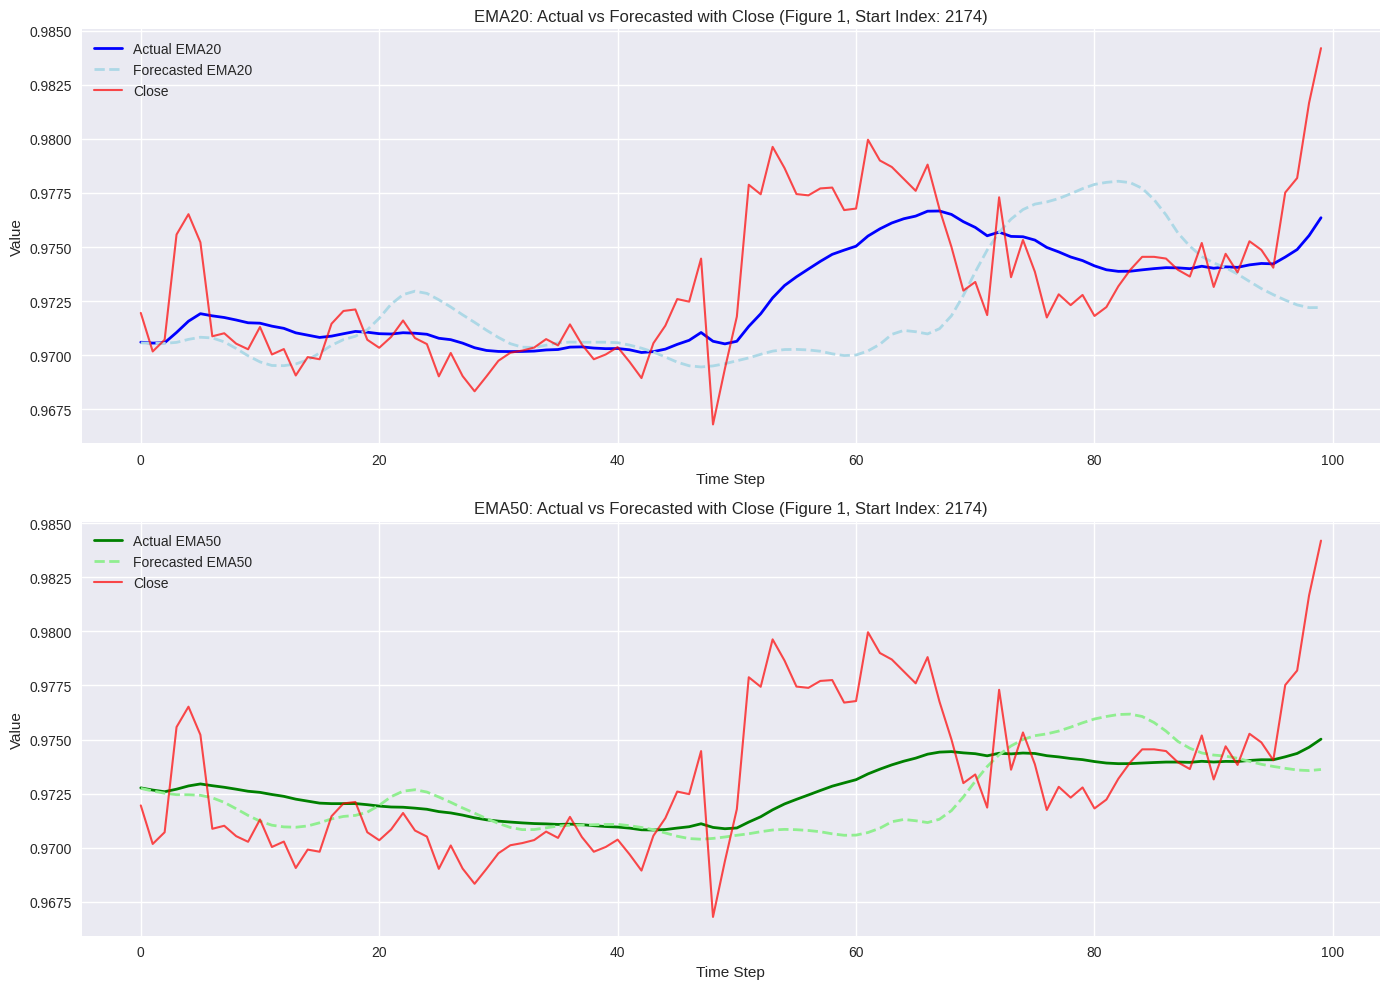

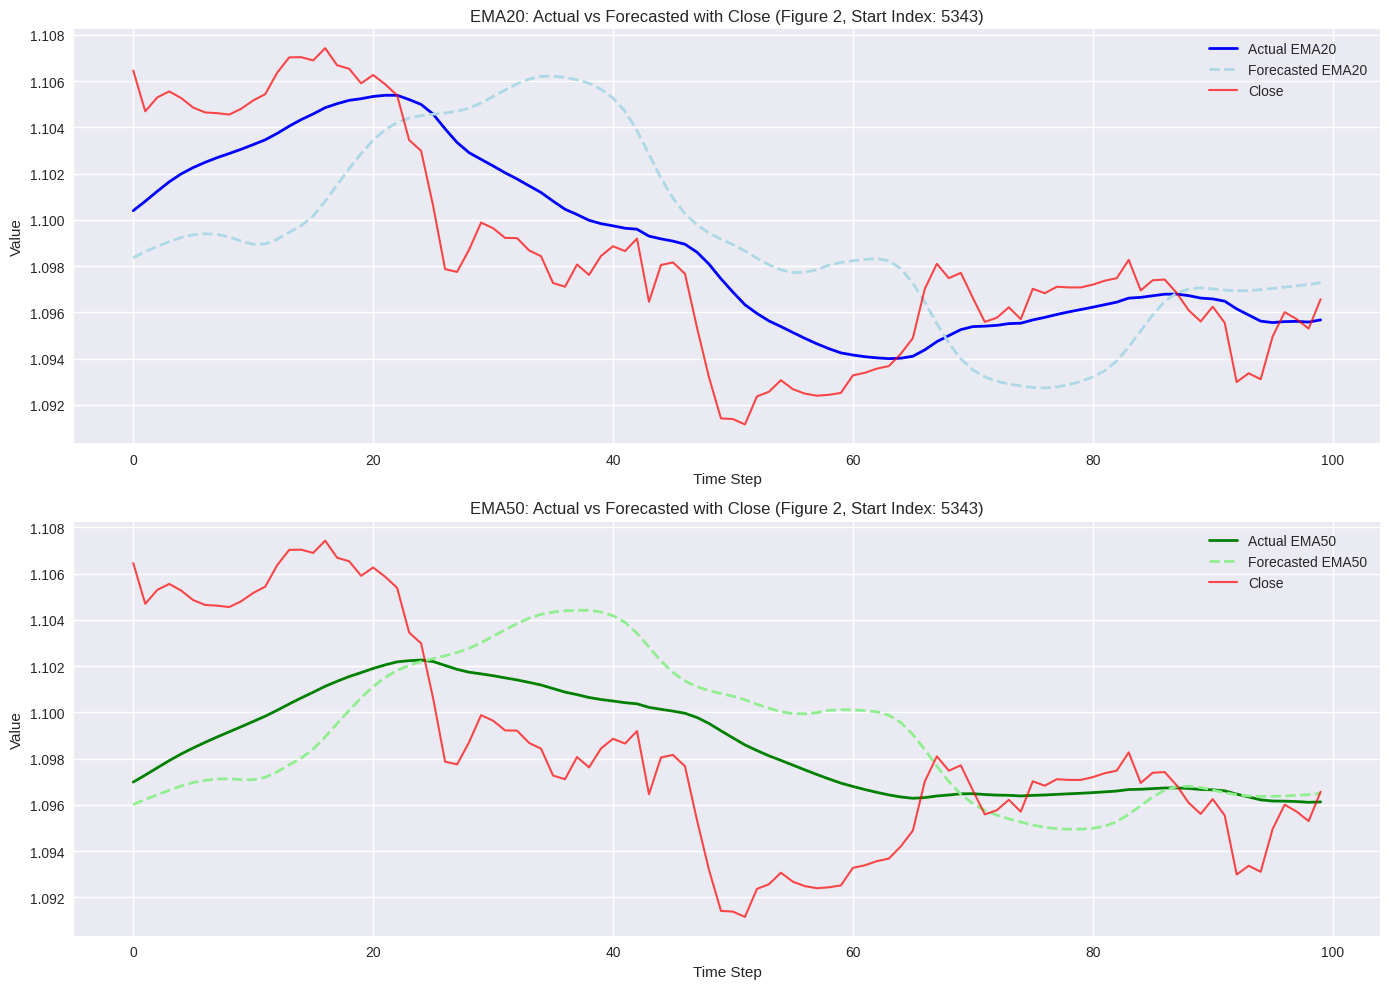

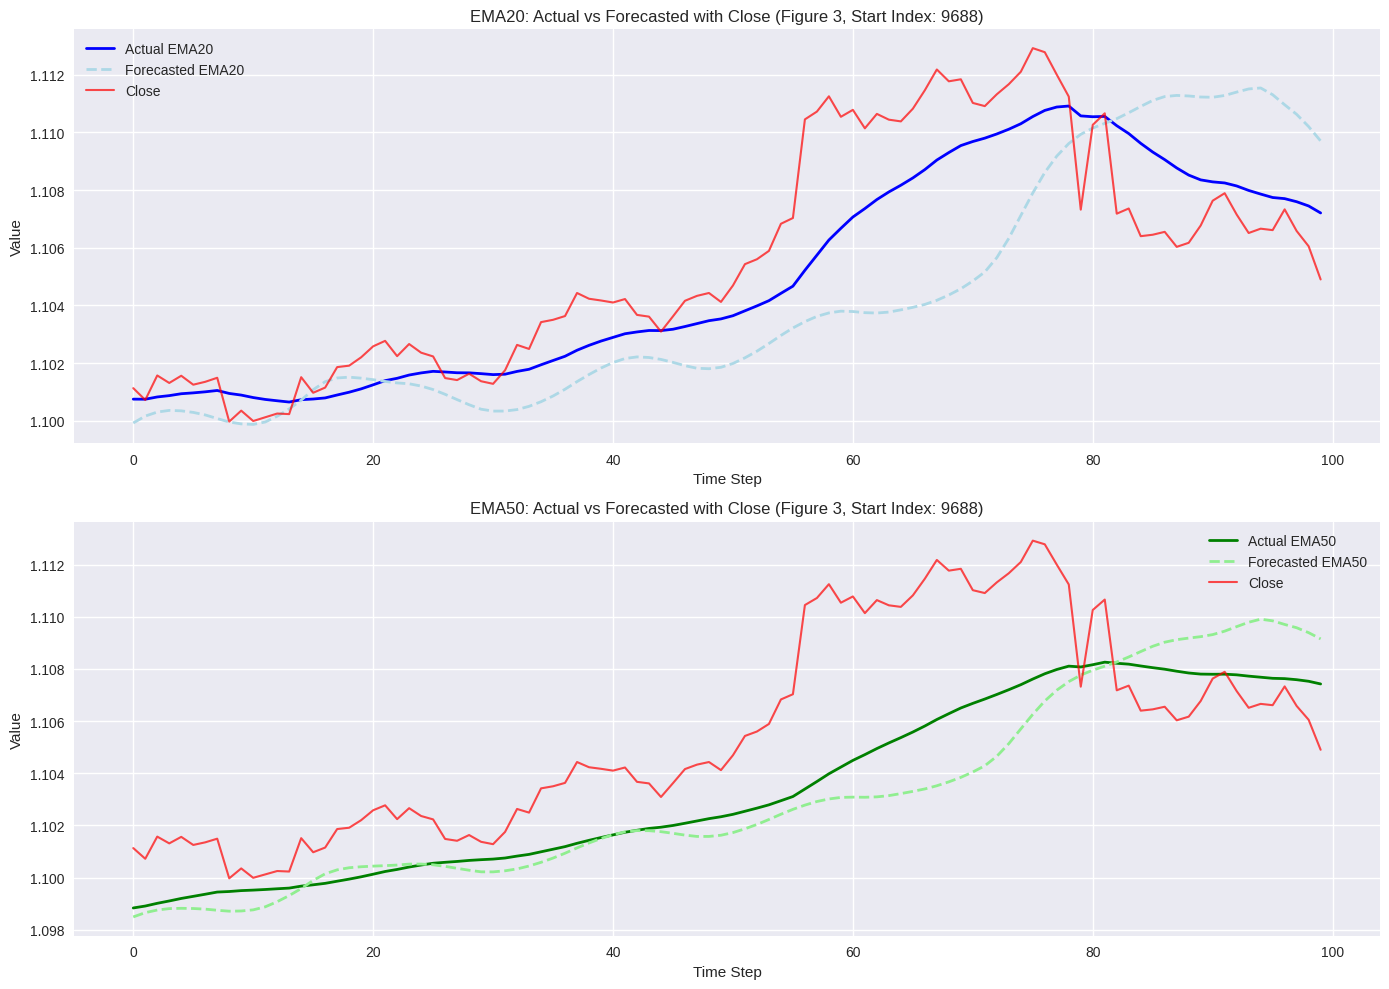

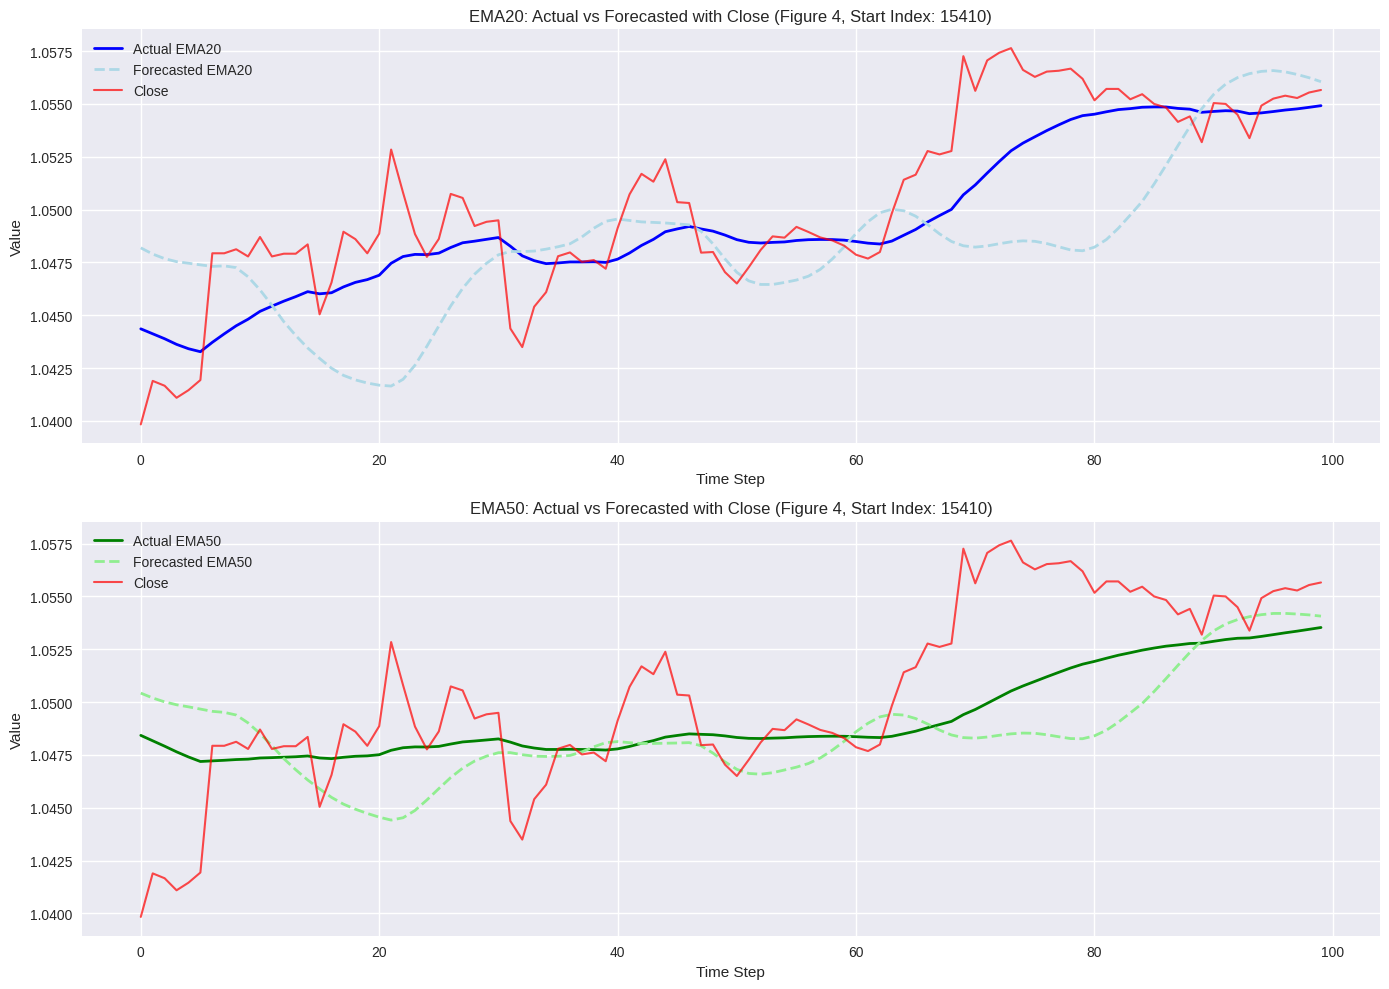

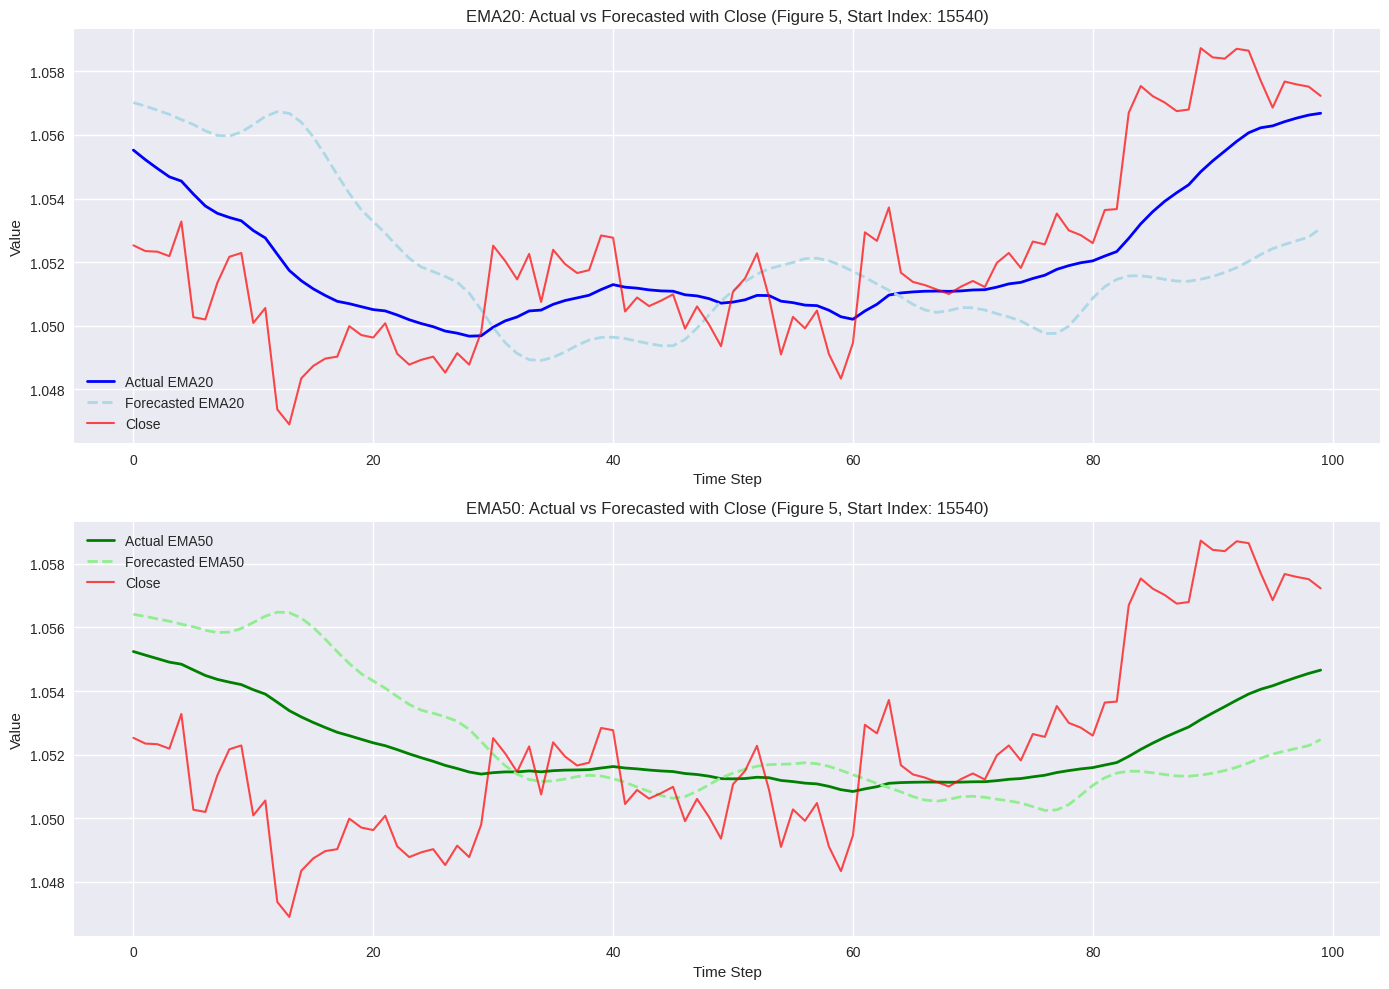

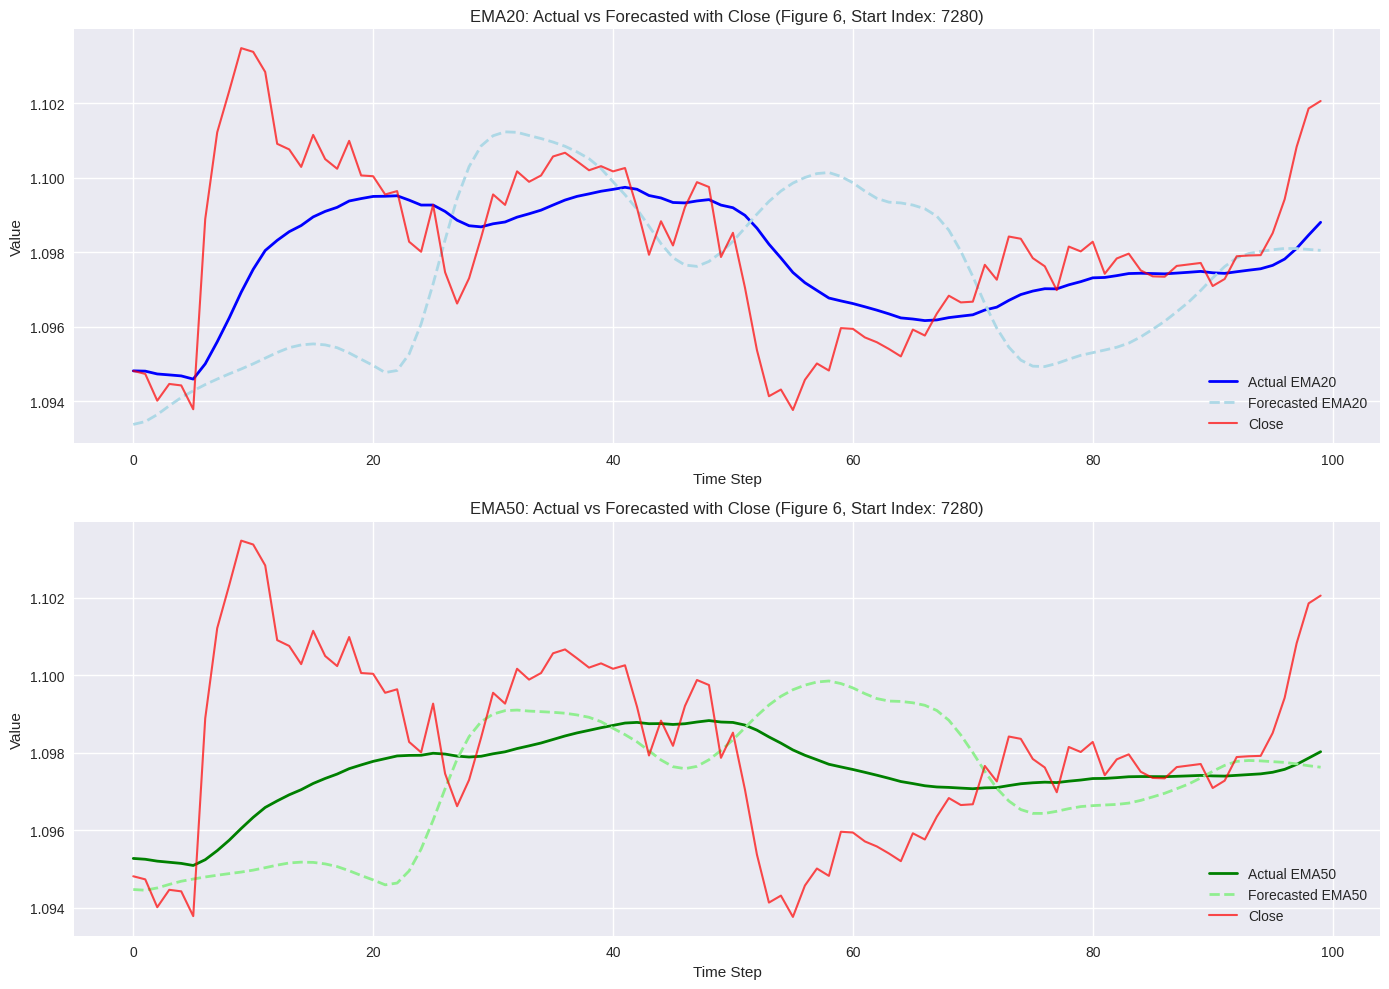

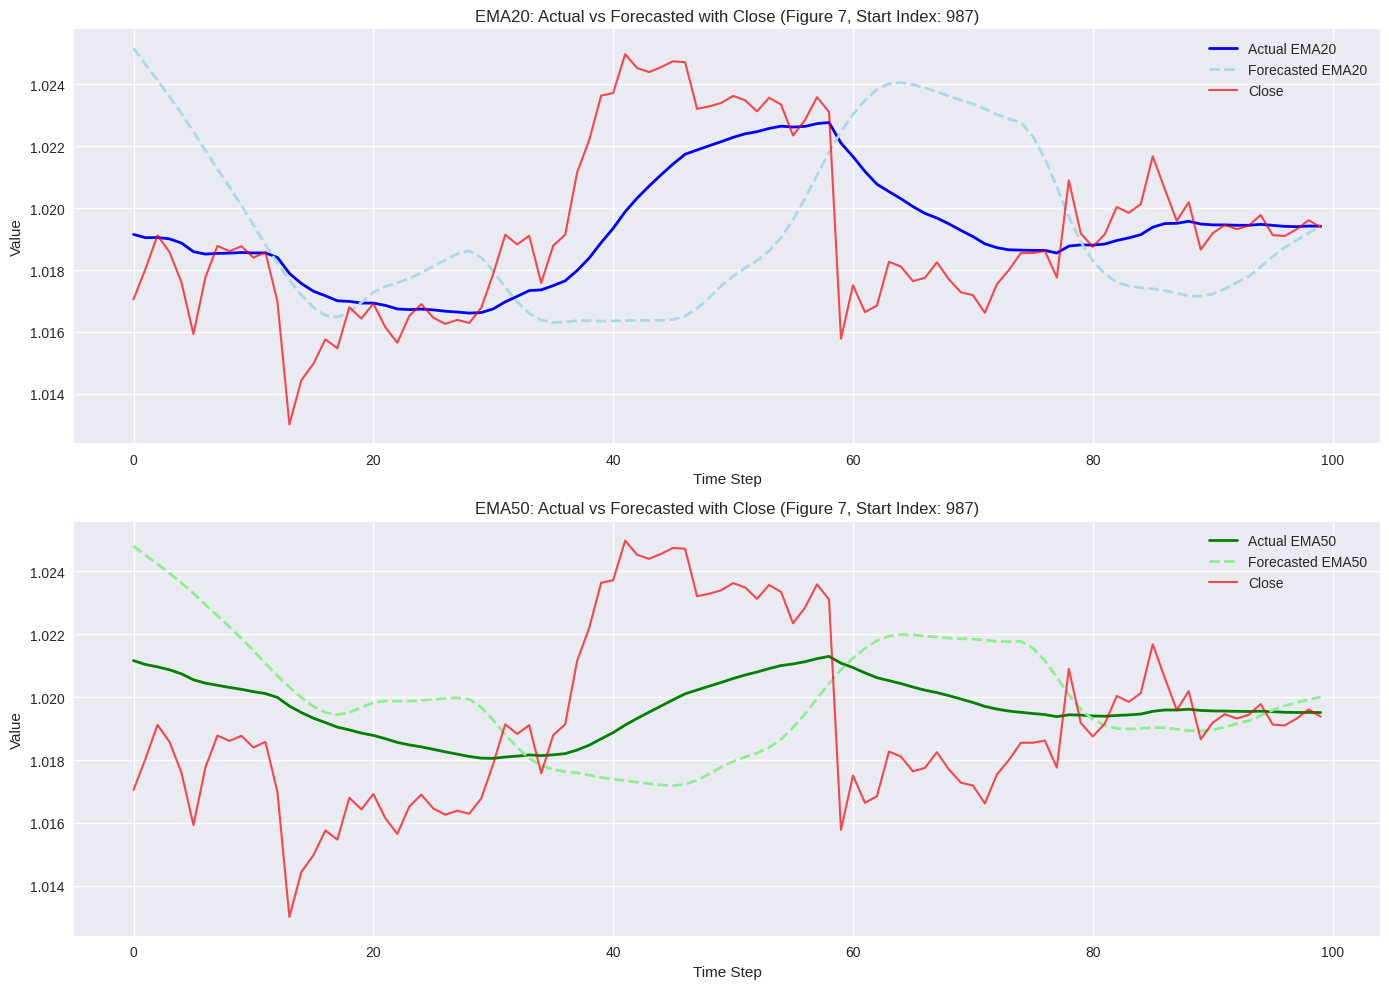

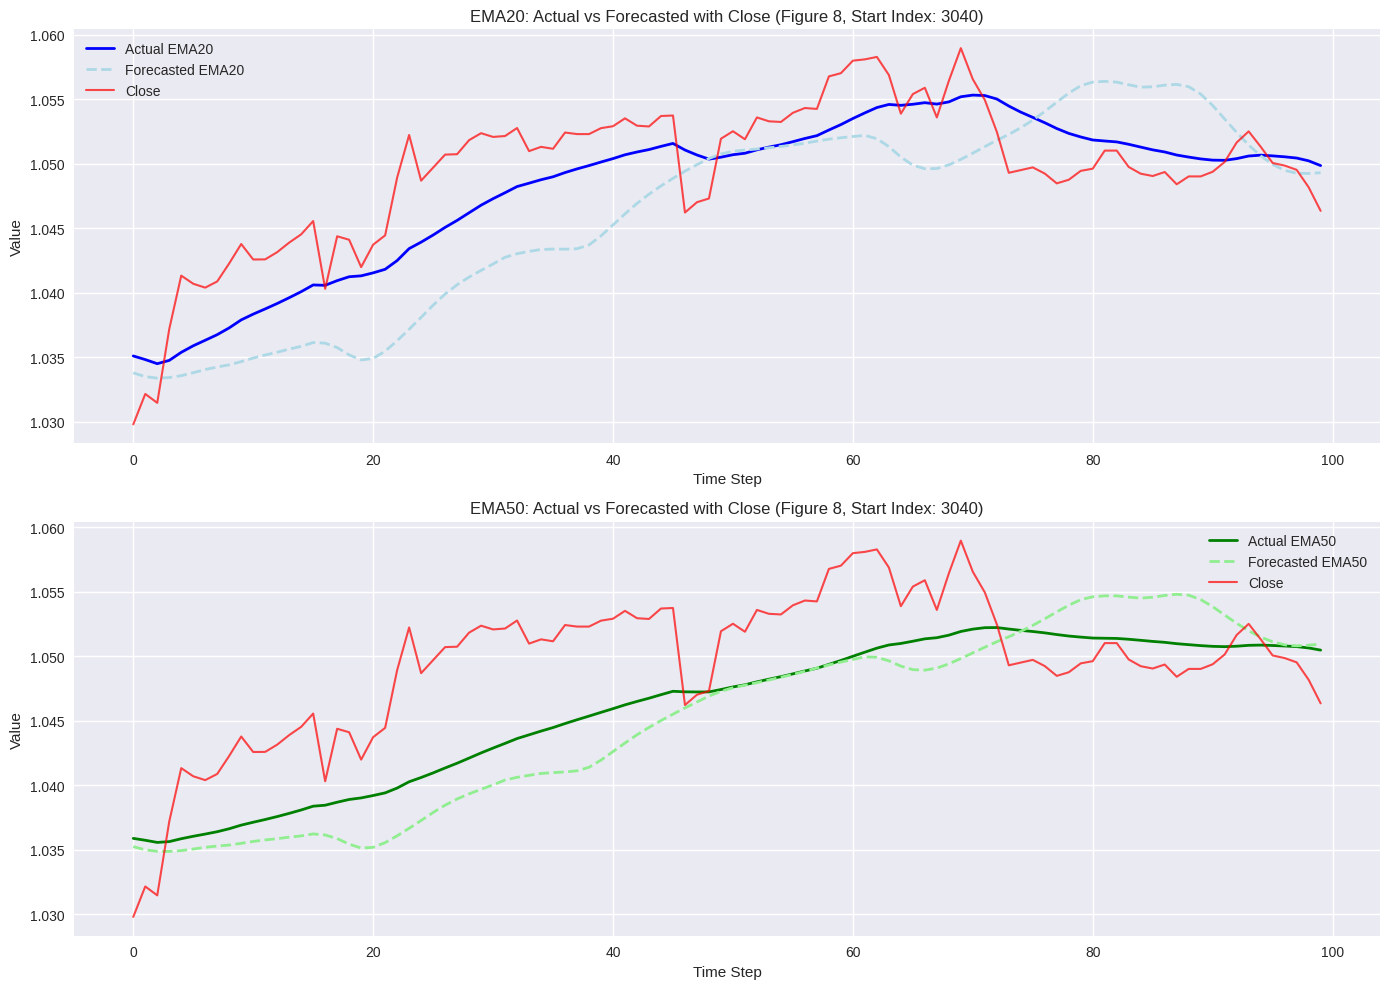

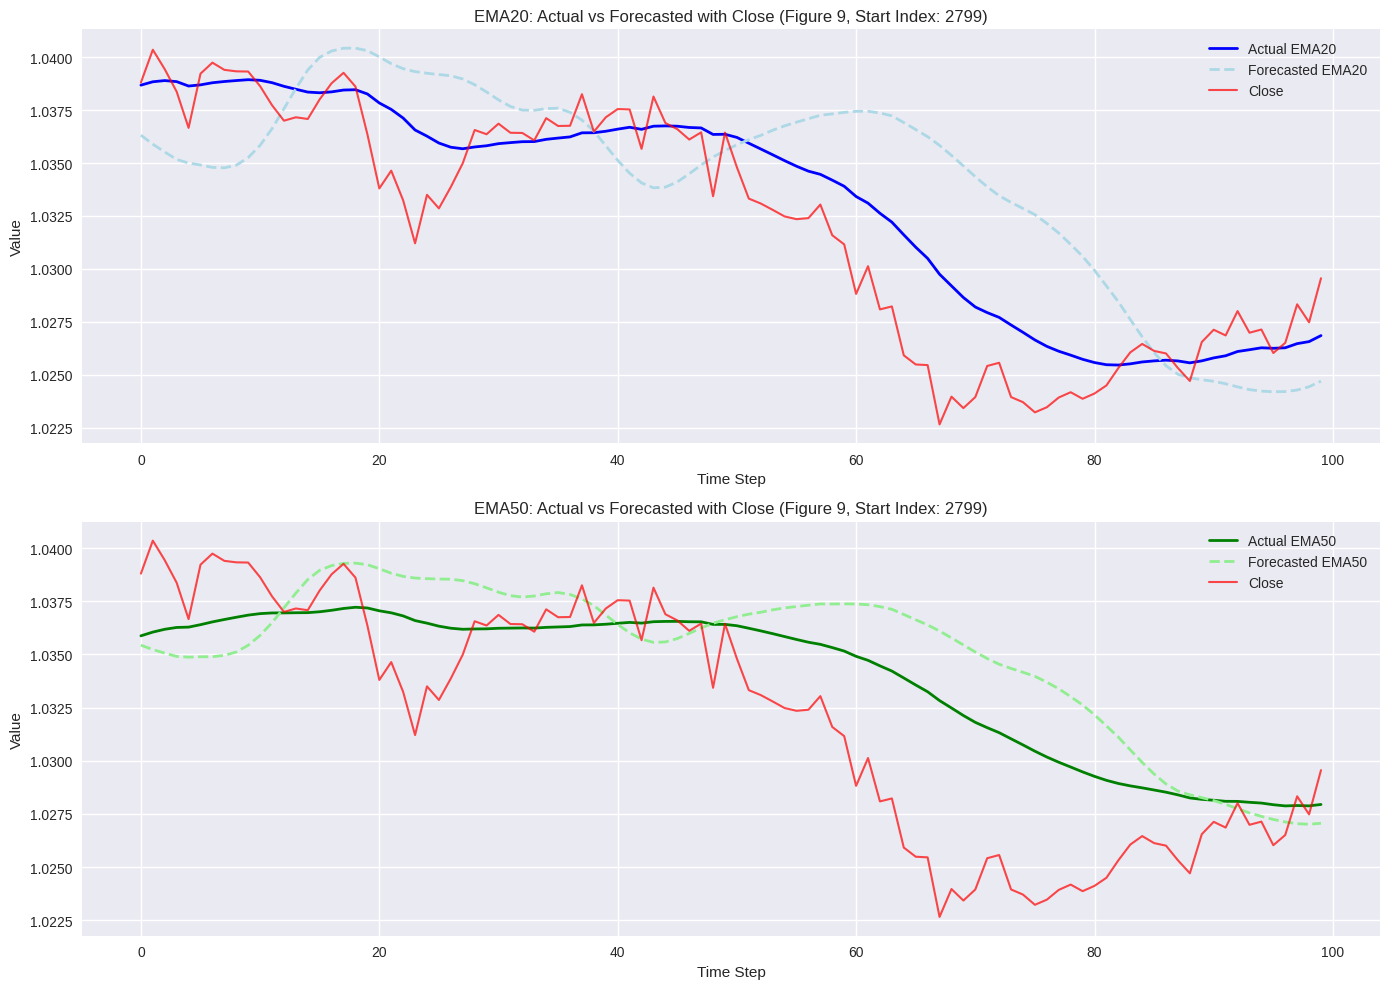

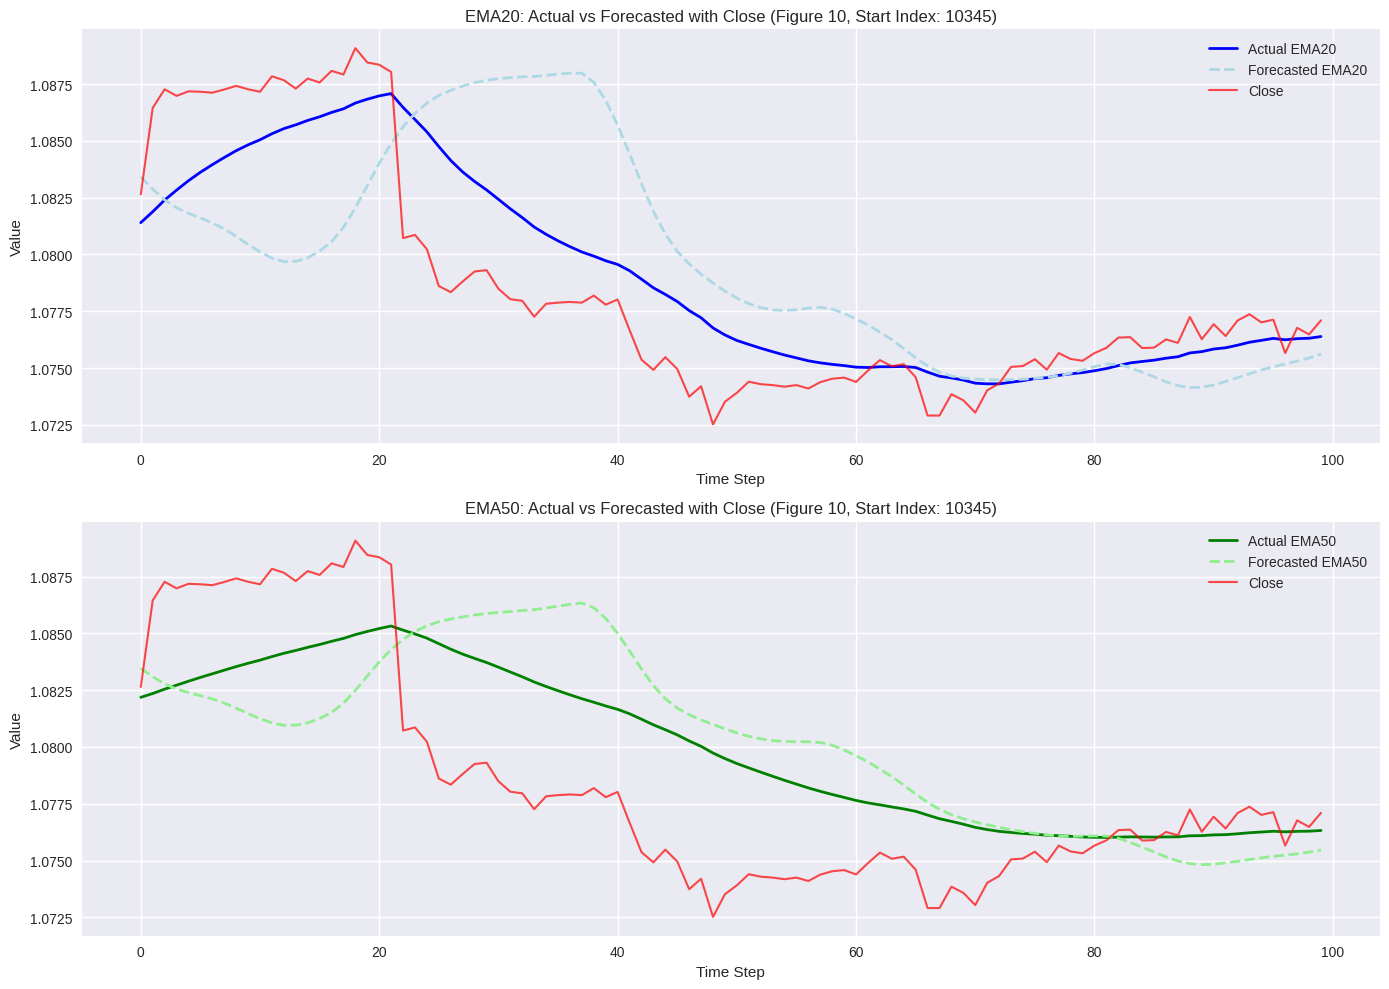

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# تنظیمات ظاهری نمودار
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 10)

# فرض می‌کنیم داده‌ها آماده هستند
# actual_ema20, actual_ema50, forecast_ema20, forecast_ema50, close_values
total_samples = len(actual_ema20)  # تعداد کل نمونه‌ها
samples_per_figure = 100  # تعداد نمونه‌ها در هر فیگور
num_figures = 10  # تعداد فیگورها

# محاسبه حداکثر نقطه شروع ممکن
# نقطه شروع باید طوری باشد که 100 نمونه متوالی بعد از آن در داده‌ها وجود داشته باشد
max_start_idx = total_samples - samples_per_figure

# انتخاب تصادفی نقاط شروع برای هر دسته
start_indices = np.random.choice(max_start_idx, size=num_figures, replace=False)

# رسم 10 فیگور
for fig_idx, start_idx in enumerate(start_indices):
    # انتخاب بازه 100 تایی متوالی
    indices = np.arange(start_idx, start_idx + samples_per_figure)
    
    # انتخاب داده‌ها برای این فیگور
    actual_ema20_subset = actual_ema20[indices]
    actual_ema50_subset = actual_ema50[indices]
    forecast_ema20_subset = np.array(forecast_ema20)[indices]
    forecast_ema50_subset = np.array(forecast_ema50)[indices]
    close_subset = close_values[indices]

    # رسم فیگور
    plt.figure()
    
    # EMA20
    plt.subplot(2, 1, 1)
    plt.plot(actual_ema20_subset, label='Actual EMA20', color='blue', linewidth=2)
    plt.plot(forecast_ema20_subset, label='Forecasted EMA20', color='lightblue', linestyle='--', linewidth=2)
    plt.plot(close_subset, label='Close', color='red', linewidth=1.5, alpha=0.7)
    plt.title(f'EMA20: Actual vs Forecasted with Close (Figure {fig_idx + 1}, Start Index: {start_idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # EMA50
    plt.subplot(2, 1, 2)
    plt.plot(actual_ema50_subset, label='Actual EMA50', color='green', linewidth=2)
    plt.plot(forecast_ema50_subset, label='Forecasted EMA50', color='lightgreen', linestyle='--', linewidth=2)
    plt.plot(close_subset, label='Close', color='red', linewidth=1.5, alpha=0.7)
    plt.title(f'EMA50: Actual vs Forecasted with Close (Figure {fig_idx + 1}, Start Index: {start_idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()